## Load-cell testing data visualization & altering

In [4]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import scienceplots

import os

import numpy as np

In [40]:
# Plot function
def plot_dict(d, xlabel='Time (ms)', ylabel='Force (N)', FILTER = False):
    plt.figure()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    color=iter(cm.tab20(np.linspace(0,1,len(d))))
    for key in d.keys():
        c=next(color)
        this_data = np.concatenate(d[key])
        # remove force=0 data
        if FILTER:
            this_data = this_data[this_data[:,1]!=0]
        plt.scatter(this_data[:,0], this_data[:,1], label=key, color=c)
    plt.legend()
    plt.show()

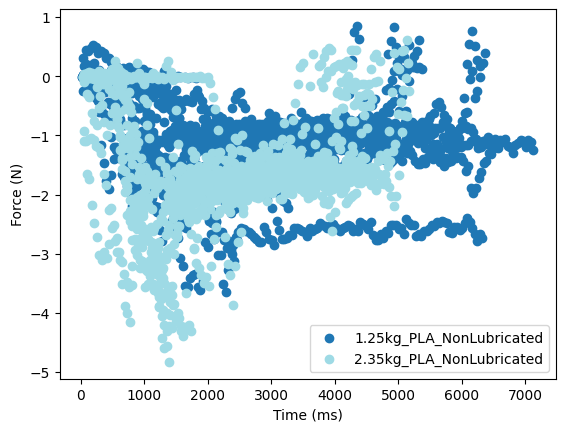

In [ ]:
# MAIN: Load & PLot data
dict_name = '3_12_force_dict.pkl'
with open(dict_name, 'rb') as f:
    force_dict = pickle.load(f)

plot_dict(force_dict, FILTER=True)

15


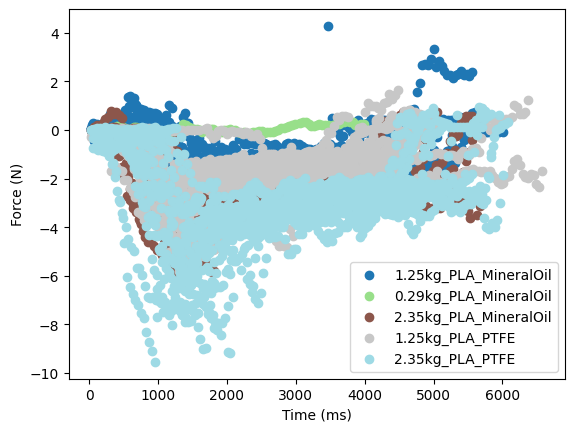

In [44]:
# MAIN: Load & PLot data
dict_name = '3_13_force_dict.pkl'
with open(dict_name, 'rb') as f:
    force_dict = pickle.load(f)

print(len(force_dict[list(force_dict.keys())[-1]]))

plot_dict(force_dict, FILTER=True)

15


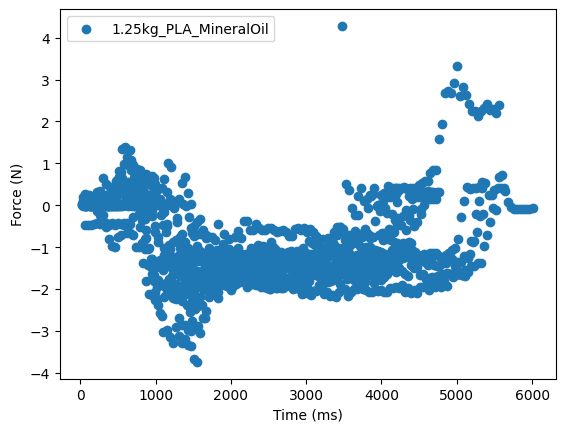

In [27]:
force_dict.keys()
print(len(force_dict[list(force_dict.keys())[-1]]))
plot_dict(force_dict, FILTER=True)